In [1]:
import argparse
import pathlib
import pickle
import random
import json
from tqdm import tqdm
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages
from python_speech_features import mel2hz
from scipy import interpolate

%matplotlib inline

In [2]:
# args = {}
# extract_path='/home/yangwenhao/local/project/SpeakerVerification-pytorch/Data/gradient/LoResNet8/vox2/klsp_egs_baseline/arcsoft/Mean_cbam_None_dp01_alpha0_em256_var/epoch_50_var_50/epoch_50'
lstm_path = '/home/work2020/yangwenhao/project/lstm_speaker_verification'
root_path='/home/yangwenhao/local/project/SpeakerVerification-pytorch/Data/gradient'
cam_method = 'fullgrad' # fullgrad  fullgrad grad_cam_pp integrad layer_cam

extract_path = root_path + '/ThinResNet34_ser06/Mean_batch256_basic_downk1_avg5_SAP2_em256_dp01_alpha0_none1_wde5_var/arcsoft_sgd_rop/vox2/123456/epoch_41_var_%s/epoch_41' % cam_method


# Training options
feat_dim = 161
samples = 23976
acoustic_feature = 'spectrogram' # choices=['fbank', 'spectrogram', 'mfcc'],
seed = 123456

random.seed(seed)
np.random.seed(seed)

In [3]:
uid2spk = {}
with open(lstm_path + '/data/vox2/dev/utt2spk', 'r') as f:
    for l in f.readlines():
        uid, sid = l.split()
        # if uid in some_data:
        uid2spk[uid] = sid
    
sid2gender = {}
with open(lstm_path + '/data/vox2/dev/spk2gender_bcp', 'r') as f:
    for l in f.readlines():
        sid, gender = l.split()
        sid2gender[sid] = gender
        
uid2gender = {}
for uid in uid2spk:
    this_sid = uid2spk[uid]
    uid2gender[uid] = sid2gender[this_sid] if this_sid in sid2gender else 'null'

In [6]:
# subsets = ['orignal', 'babble', 'noise', 'music', 'reverb']
# load selected input uids
dir_path = pathlib.Path(extract_path)
print('Path: %s' % str(dir_path))

load_from_pickle = True # load saved gradient and data 
# inputs [train/valid/test]
if load_from_pickle and os.path.exists(extract_path + '/data_grad.pickle'):
    print('  Loading ... ')
    with open(extract_path + '/data_grad.pickle', 'rb') as f:
        time_data = pickle.load(f)  # avg on time axis
    with open(extract_path + '/data_grad.uid.json', 'r') as f:
        time_data_uid = json.load(f)  # avg on freq axis
else:
    train_lst = list(dir_path.glob('*train*bin'))
    train_id_lst = list(dir_path.glob('*train*json'))

    print(' Train set binary reading:')
    time_data = []
    num_utt = 0
    for t in train_lst:
        p = str(t)
        with open(p, 'rb') as f:
            for (data, grad) in tqdm(pickle.load(f), ncols=50):
                time_data.append((data, grad))
                num_utt += 1
                if num_utt >= samples:
                    break
    with open(extract_path + '/data_grad.pickle', 'wb') as f:
        pickle.dump(time_data, f, protocol=pickle.HIGHEST_PROTOCOL)

    time_data_uid = []
    num_utt = 0
    for t in train_id_lst:
        with open(str(t), 'r') as f:
            for uid in json.load(f):
                time_data_uid.append(uid[0])
                num_utt += 1
                if num_utt >= samples:
                    break
    with open(extract_path + '/data_grad.uid.json', 'w') as f:
        json.dump(time_data_uid, f)

Path: /home/yangwenhao/local/project/SpeakerVerification-pytorch/Data/gradient/ThinResNet34_ser06/Mean_batch256_basic_downk1_avg5_SAP2_em256_dp01_alpha0_none1_wde5_var/arcsoft_sgd_rop/vox2/123456/epoch_41_var_fullgrad/epoch_41
 Train set binary reading:


100%|███▉| 2499/2500 [00:00<00:00, 2518396.37it/s]


In [7]:
some_data = {}
for uid,(data, grad) in zip(time_data_uid, time_data):
    some_data[uid]=[data, grad]
print(list(some_data.keys())[:4])

['id02871-gMP14u5j0Yo-00182', 'id01630-IYDzlmFgg2g-00015', 'id06299-_BwBE0I3Sbg-00044', 'id07649-CMR98OzwhWs-00046']


100%|██████| 23395/23395 [01:06<00:00, 350.73it/s]


The number of males and females are 14435 and 8960.


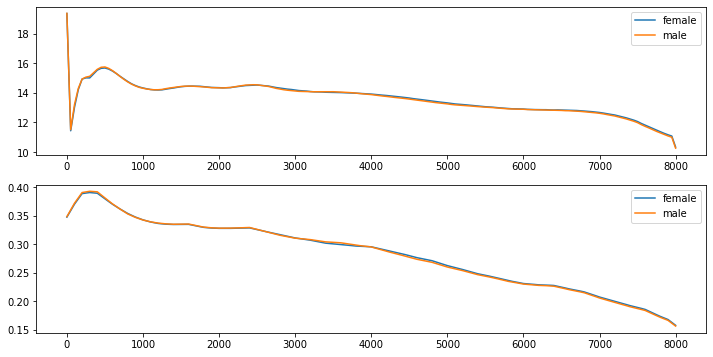

In [8]:
train_input_f = np.zeros((feat_dim))
train_input_m = np.zeros((feat_dim))
grad_input_f = np.zeros((feat_dim))
grad_input_m = np.zeros((feat_dim))

males = 0
for uid in tqdm(some_data, ncols=50):
    gender = uid2gender[uid]
    data, grad = some_data[uid]
    if np.isnan(grad).sum()>0:
        print("Skip %s with shape %s" %(uid, str(grad.shape)))
        continue
    if gender == 'f':
        train_input_f += data.mean(axis=0)
        grad_input_f  += np.abs(grad).mean(axis=0)
    else:
        males += 1
        train_input_m += data.mean(axis=0)
        grad_input_m  += np.abs(grad).mean(axis=0)
        
females = len(some_data) - males
print("The number of males and females are %d and %d." %(males, females))
train_input_f /= females
train_input_m /= males
grad_input_f /= females
grad_input_m /= males
# print(grad_input_f, grad_input_m)

plt.figure(figsize=(12, 6))

x = np.linspace(0, 8000, 161)
for i,(f,m) in enumerate([(train_input_f, train_input_m), (grad_input_f, grad_input_m)]):
    ax = plt.subplot(2, 1, i+1)
    ax.plot(x, f)
    ax.plot(x, m)
    ax.legend(['female', 'male'])

plt.savefig('data/v1_mean_%s.png'%cam_method, bbox_inches='tight')

100%|█████| 23395/23395 [00:10<00:00, 2216.79it/s]


The number of males and females are 14435 and 8960.


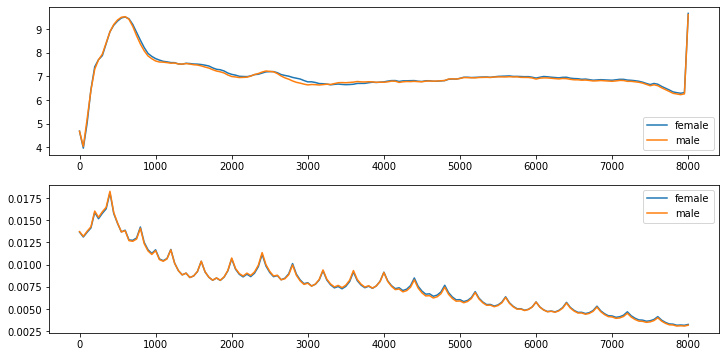

In [9]:
train_input_f = np.zeros((feat_dim))
train_input_m = np.zeros((feat_dim))
grad_input_f = np.zeros((feat_dim))
grad_input_m = np.zeros((feat_dim))

males = 0
for uid in tqdm(some_data, ncols=50):
    gender = uid2gender[uid]
    data, grad = some_data[uid]
    if np.isnan(grad).sum()>0:
        print("Skip %s with shape %s" %(uid, str(grad.shape)))
        continue
    if gender == 'f':
        train_input_f += data.var(axis=0)
        grad_input_f  += grad.var(axis=0)
    else:
        males += 1
        train_input_m += data.var(axis=0)
        grad_input_m  += grad.var(axis=0)
        
females = len(some_data) - males
print("The number of males and females are %d and %d." %(males, females))
train_input_f /= females
train_input_m /= males
grad_input_f /= females
grad_input_m /= males
# print(grad_input_f, grad_input_m)

plt.figure(figsize=(12, 6))

x = np.linspace(0, 8000, 161)
for i,(f,m) in enumerate([(train_input_f, train_input_m), (grad_input_f, grad_input_m)]):
    ax = plt.subplot(2, 1, i+1)
    ax.plot(x, f)
    ax.plot(x, m)
    ax.legend(['female', 'male'])
    
plt.savefig('data/v1_var_%s.png'%cam_method, bbox_inches='tight')

In [10]:
spk2frames, spk2grads = {}, {}
print(' Append utterances ... ')
for uid in tqdm(some_data, ncols=50):
    sid = uid2spk[uid]
    data, grad = some_data[uid]

    spk2frames.setdefault(sid, []).append(data)
    spk2grads.setdefault(sid, []).append(grad)

print(' Stack utterances ... ')
all_frames = np.zeros((feat_dim))
all_grads = np.zeros((feat_dim))
uid_length = []

print(' Sum frames ... ')
for sid in tqdm(spk2frames, ncols=50):
    stack_frames = np.concatenate(spk2frames[sid], axis=0)
    all_frames += np.sum(stack_frames, axis=0)
    
    stack_frames = np.concatenate(spk2grads[sid], axis=0)
    all_grads  += np.sum(stack_frames, axis=0)
    uid_length.append(len(stack_frames))
    
all_frames_mean = all_frames / np.sum(uid_length)
all_grads_mean = all_grads / np.sum(uid_length)
del all_frames, all_grads

spk_frames_mean = np.array([np.concatenate(spk2frames[s], axis=0).mean(axis=0) for s in spk2frames])
spk_grads_mean = np.array([np.concatenate(spk2grads[s], axis=0).mean(axis=0) for s in spk2grads])

print(' Compute between_variance ... ')
between_frames = np.power((spk_frames_mean - all_frames_mean), 2).sum(axis=0)
between_grads = np.power((spk_grads_mean - all_grads_mean), 2).sum(axis=0)

print(' Compute within_variance ... ')
within_frames = np.array([np.concatenate(spk2frames[s], axis=0).var(axis=0) for s in spk2frames]).sum(axis=0)
within_grads  = np.array([np.concatenate(spk2grads[s], axis=0).var(axis=0) for s in spk2grads]).sum(axis=0)

 Append utterances ... 


100%|████| 23395/23395 [00:01<00:00, 15332.36it/s]


 Stack utterances ... 
 Sum frames ... 


100%|███████| 5892/5892 [00:03<00:00, 1487.20it/s]


 Compute between_variance ... 
 Compute within_variance ... 


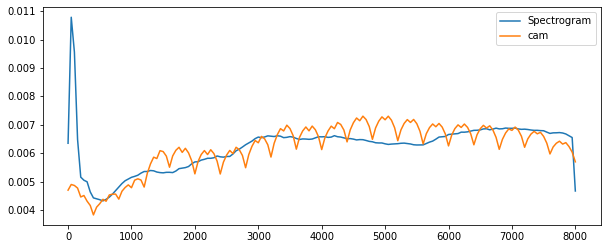

In [11]:
plt.figure(figsize=(10, 4))
x = np.linspace(0, 8000, 161)
for i,(f,m) in enumerate([(between_frames, within_frames), (between_grads, within_grads)]):
    y = f/m
    y /= y.sum()
    plt.plot(x, y)
plt.legend(['Spectrogram', 'cam'])
plt.savefig('data/v1_%s_fratio.png'%(cam_method), bbox_inches='tight')

In [12]:
spk2frames, spk2grads = {}, {}
print(' Append utterances ... ')
for uid in tqdm(some_data, ncols=50):
    sid = uid2spk[uid]
    data, grad = some_data[uid]

    spk2frames.setdefault(sid, []).append(data)
    # spk2grads.setdefault(sid, []).append(np.abs(grad))
    spk2grads.setdefault(sid, []).append(np.clip(grad, a_min=0, a_max=None))

print(' Stack utterances ... ')
all_frames = np.zeros((feat_dim))
all_grads = np.zeros((feat_dim))
uid_length = []

print(' Sum frames ... ')
for sid in tqdm(spk2frames, ncols=50):
    stack_frames = np.concatenate(spk2frames[sid], axis=0)
    all_frames += np.sum(stack_frames, axis=0)
    
    stack_frames = np.concatenate(spk2grads[sid], axis=0)
    all_grads  += np.sum(stack_frames, axis=0)
    uid_length.append(len(stack_frames))
    
all_frames_mean = all_frames / np.sum(uid_length)
all_grads_mean = all_grads / np.sum(uid_length)
del all_frames, all_grads

print(' Compute speaker mean ... ')
spk_frames_mean = np.array([np.concatenate(spk2frames[s], axis=0).mean(axis=0) for s in spk2frames])
spk_grads_mean = np.array([np.concatenate(spk2grads[s], axis=0).mean(axis=0) for s in spk2grads])

print(' Compute between_variance ... ')
between_frames = np.power((spk_frames_mean - all_frames_mean), 2).sum(axis=0)
between_grads = np.power((spk_grads_mean - all_grads_mean), 2).sum(axis=0)

print(' Compute within_variance ... ')
within_frames = np.array([np.concatenate(spk2frames[s], axis=0).var(axis=0) for s in spk2frames]).sum(axis=0)
within_grads  = np.array([np.concatenate(spk2grads[s], axis=0).var(axis=0) for s in spk2grads]).sum(axis=0)

 Append utterances ... 


100%|██████| 23395/23395 [03:07<00:00, 124.83it/s]


 Stack utterances ... 
 Sum frames ... 


100%|█████████| 5892/5892 [02:00<00:00, 48.94it/s]


 Compute speaker mean ... 
 Compute between_variance ... 
 Compute within_variance ... 


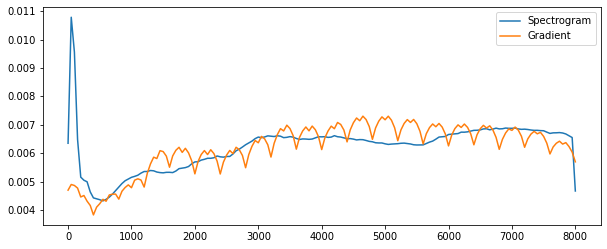

In [13]:
plt.figure(figsize=(10, 4))
x = np.linspace(0, 8000, 161)
for i,(f,m) in enumerate([(between_frames, within_frames), (between_grads, within_grads)]):
    y = f/m
    y /= y.sum()
    plt.plot(x, y)
plt.legend(['Spectrogram', 'Gradient'])
plt.savefig('data/v1_%s_fratio_relu.png'%(cam_method), bbox_inches='tight')

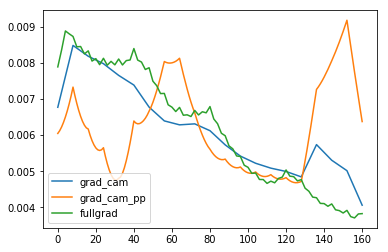

In [54]:
for cam_method in ["grad_cam", "grad_cam_pp", "fullgrad"]:
    weight_path='/home/yangwenhao/local/project/SpeakerVerification-pytorch/Data/gradient/LoResNet8/vox2/klsp_egs_baseline/arcsoft/Mean_cbam_None_dp01_alpha0_em256_var/epoch_61_var_%s/epoch_61' % cam_method
    with open(weight_path + '/freq.data.pickle', 'rb') as f:
        freq_weight = pickle.load(f)
    this_weight = freq_weight['train.time.mean']
    plt.plot(this_weight/this_weight.sum())
plt.legend(["grad_cam", "grad_cam_pp", "fullgrad"])
  

[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]


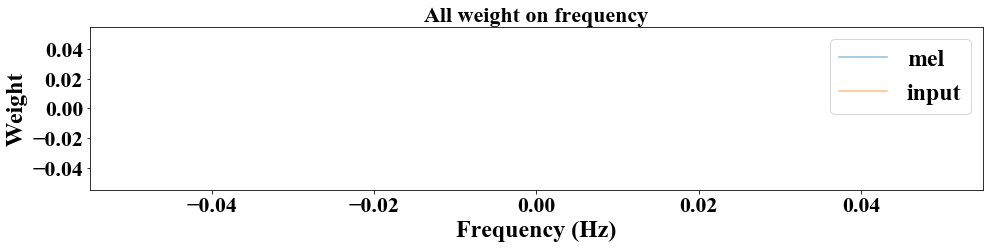

In [25]:
# all_data [5, 2, 120, 161]
# plotting filters distributions

# train_data [numofutt, feats[N, 161]]
train_input = freq_data['train.data.mean']
valid_input = freq_data['valid.data.mean']
train_grad = freq_data['train.time.mean']
train_grad_part = freq_data['train.time.mean.part']
print(train_grad)
valid_grad = freq_data['valid.time.mean']

x = np.arange(feat_dim) * 8000 / (feat_dim - 1)  # [0-8000]
if acoustic_feature == 'fbank':
    m = np.linspace(0, 2840.0230467083188, feat_dim)
    x = mel2hz(m)

# y = np.sum(all_data, axis=2)  # [5, 2, 162]
plt.rc('font', family='Times New Roman')

plt.figure(figsize=(16, 3))
# plt.title('Gradient Distributions', fontsize=22)
plt.title('All weight on frequency', fontsize=22)
plt.xlabel('Frequency (Hz)', fontsize=24)
plt.xticks(fontsize=22)
plt.ylabel('Weight', fontsize=24)
plt.yticks(fontsize=22)

m = np.arange(0, 2840.0230467083188)
m = 700 * (10 ** (m / 2595.0) - 1)
n = np.array([m[i] - m[i - 1] for i in range(1, len(m))])
n = 1 / n

f = interpolate.interp1d(m[1:], n)
xnew = np.arange(np.min(m[1:]), np.max(m[1:]), (np.max(m[1:]) - np.min(m[1:])) / 161)
ynew = f(xnew)
ynew = ynew / ynew.sum()#.max()
# plt.plot(xnew, ynew)
# print(np.sum(ynew))

# for s in train_grad, valid_grad, veri_grad, veri_grad_relu, test_grad:
# for s in veri_grad, veri_grad_relu:
# for s in train_grad, veri_grad, test_grad:
# for s in (np.abs(train_grad),train_grad_part) :
for s in (train_grad_part, train_grad) :


    # for s in test_a_set_grad, test_b_set_grad:
    f = interpolate.interp1d(x, s)
    xnew = np.linspace(np.min(x), np.max(x), 161)
    ynew = f(xnew)
    ynew = ynew / ynew.sum() #.max()
    plt.plot(xnew, ynew, alpha=0.5)
    # pdb.set_trace
# if not os.path.exists(args.extract_path + '/grad.npy'):
ynew = train_grad
ynew = ynew / ynew.sum()

# np.save(extract_path + '/train.grad.veri.npy', veri_grad)

# plt.legend(['Mel-scale', 'Train', 'Valid', 'Test_a', 'Test_b'], loc='upper right', fontsize=18)
# plt.legend(['Train', 'Valid', 'Train Verify', 'Train Verify Relu', 'Test'], loc='upper right', fontsize=24)
plt.legend(['mel', 'input','Train', 'Train Verify', 'Test'], loc='upper right', fontsize=24)

# plt.legend(['input', 'Train Verify', 'Train Verify Relu'], loc='upper right', fontsize=24)

# plt.legend(['Mel-scale', 'Train', 'Valid', 'Train Verify', 'Test'], loc='upper right', fontsize=24)
# pdf.savefig()
# pdf.close()

# plt.savefig(args.extract_path + "/grads.png")
plt.show()

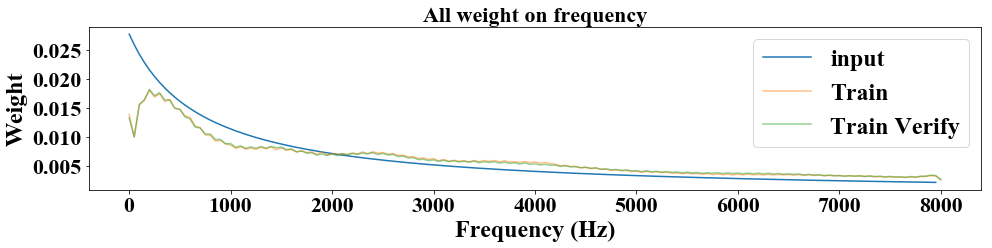

In [22]:
# all_data [5, 2, 120, 161]
# plotting filters distributions

# train_data [numofutt, feats[N, 161]]
train_input = freq_data['train.data.mean']
valid_input = freq_data['valid.data.mean']
test_input = freq_data['test.veri.data.mean']

train_grad = freq_data['train.time.mean']
train_grad_part = freq_data['train.time.mean.part']

valid_grad = freq_data['valid.time.mean']
veri_grad = freq_data['train.veri.time.mean']
veri_grad_relu = freq_data['train.veri.time.relu']

te3t_grad = freq_data['test.veri.time.mean']
test_grad_relu = freq_data['test.veri.time.relu']

x = np.arange(feat_dim) * 8000 / (feat_dim - 1)  # [0-8000]
if acoustic_feature == 'fbank':
    m = np.linspace(0, 2840.0230467083188, feat_dim)
    x = mel2hz(m)

# y = np.sum(all_data, axis=2)  # [5, 2, 162]
plt.rc('font', family='Times New Roman')

plt.figure(figsize=(16, 3))
# plt.title('Gradient Distributions', fontsize=22)
plt.title('All weight on frequency', fontsize=22)
plt.xlabel('Frequency (Hz)', fontsize=24)
plt.xticks(fontsize=22)
plt.ylabel('Weight', fontsize=24)
plt.yticks(fontsize=22)

m = np.arange(0, 2840.0230467083188)
m = 700 * (10 ** (m / 2595.0) - 1)
n = np.array([m[i] - m[i - 1] for i in range(1, len(m))])
n = 1 / n

f = interpolate.interp1d(m[1:], n)
xnew = np.arange(np.min(m[1:]), np.max(m[1:]), (np.max(m[1:]) - np.min(m[1:])) / 161)
ynew = f(xnew)
ynew = ynew / ynew.sum()#.max()
plt.plot(xnew, ynew)
# print(np.sum(ynew))

# for s in train_grad, valid_grad, veri_grad, veri_grad_relu, test_grad:
# for s in veri_grad, veri_grad_relu:
# for s in train_grad, veri_grad, test_grad:
# for s in (np.abs(train_grad),train_grad_part) :
for s in (train_grad_part, veri_grad) :


    # for s in test_a_set_grad, test_b_set_grad:
    f = interpolate.interp1d(x, s)
    xnew = np.linspace(np.min(x), np.max(x), 161)
    ynew = f(xnew)
    ynew = ynew / ynew.sum() #.max()
    plt.plot(xnew, ynew, alpha=0.5)
    # pdb.set_trace
# if not os.path.exists(args.extract_path + '/grad.npy'):
ynew = veri_grad
ynew = ynew / ynew.sum()

np.save(extract_path + '/train.grad.veri.npy', veri_grad)

# plt.legend(['Mel-scale', 'Train', 'Valid', 'Test_a', 'Test_b'], loc='upper right', fontsize=18)
# plt.legend(['Train', 'Valid', 'Train Verify', 'Train Verify Relu', 'Test'], loc='upper right', fontsize=24)
plt.legend(['input','Train', 'Train Verify', 'Test'], loc='upper right', fontsize=24)

# plt.legend(['input', 'Train Verify', 'Train Verify Relu'], loc='upper right', fontsize=24)

# plt.legend(['Mel-scale', 'Train', 'Valid', 'Train Verify', 'Test'], loc='upper right', fontsize=24)
# pdf.savefig()
# pdf.close()

# plt.savefig(args.extract_path + "/grads.png")
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
plt.title('Data distributions', fontsize=22)
plt.xlabel('Frequency (Hz)', fontsize=16)
plt.ylabel('Log Power (-)', fontsize=16)
# 插值平滑 ？？？
for s in train_input, valid_input, test_input:
    # for s in test_a_set_grad, test_b_set_grad:
    f = interpolate.interp1d(x, s)
    xnew = np.linspace(np.min(x), np.max(x), 161)
    ynew = f(xnew)
    plt.plot(xnew, ynew)

plt.legend(['Train', 'Valid', 'Test'], loc='upper right', fontsize=16)
# plt.savefig(args.extract_path + "/inputs.freq.png")
plt.show()

In [ ]:
plt.figure(figsize=(16, 8))
plt.title('Data distributions in Time Axis', fontsize=22)
plt.xlabel('Time', fontsize=16)
plt.ylabel('Magnetitude', fontsize=16)
# 插值平滑 ？？？
# for i, (data, grad) in enumerate(time_data):
# for s in test_a_set_grad, test_b_set_grad:
data = time_data[0][0]
grad = time_data[0][1]
norm = matplotlib.colors.Normalize(vmin=0., vmax=1.)
# data_mean = data.mean(axis=10

ax = plt.subplot(2, 1, 1)

# data = (data - data.min()) / (data.max() - data.min())
# im = ax.imshow(np.log(data.transpose()), cmap='viridis', aspect='auto')
im = ax.imshow(data.transpose(), cmap='viridis', aspect='auto')
# print(data.min(), data.max())
plt.colorbar(im)  # 显示颜色标尺
# ax.plot(data_mean)

ax = plt.subplot(2, 1, 2)
grad = np.abs(grad)
grad_mean = grad
# grad_mean = (grad - grad.min()) / (grad.max() - grad.min())
# im = ax.imshow(1/np.log(grad_mean.transpose()), norm=norm, cmap='viridis', aspect='auto')
im = ax.imshow(grad_mean.transpose(), cmap='viridis', aspect='auto')
# ax.plot(np.log(grad_mean))
ax.set_xlim(0, len(grad_mean))

# plt.legend(['Train', 'Valid', 'Test'], loc='upper right', fontsize=16)
plt.colorbar(im)  # 显示颜色标尺
# plt.savefig(args.extract_path + "/inputs.time.png")
plt.show()

print('Completed!\n')